# Recuperação dos dados

In [85]:
import os

#Dados obtivos de https://github.com/amitt001/Android-App-Reviews-Dataset
URL_ROOT = 'https://raw.githubusercontent.com/amitt001/Android-App-Reviews-Dataset/master/'

POSITIVE_REVIEWS_DATA_URL = URL_ROOT+'positive10k.txt'
NEGATIVE_REVIEWS_DATA_URL = URL_ROOT+'negative10k.txt'

DATA_PATH = os.path.join('..', 'data', 'raw')
POSITIVE_DATA_FILE = os.path.join(DATA_PATH, 'positive10k.txt')
NEGATIVE_DATA_FILE = os.path.join(DATA_PATH, 'negative10k.txt')


In [86]:
import urllib

def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    urllib.request.urlretrieve(data_url, data_file)

download_data(POSITIVE_REVIEWS_DATA_URL, DATA_PATH, POSITIVE_DATA_FILE)
download_data(NEGATIVE_REVIEWS_DATA_URL, DATA_PATH, NEGATIVE_DATA_FILE)

In [87]:
import pandas as pd

positive_df = pd.read_csv(POSITIVE_DATA_FILE,  delimiter = "\t", header=None, names=['reviews'])
negative_df = pd.read_csv(NEGATIVE_DATA_FILE,  delimiter = "\t", header=None, names=['reviews'])

In [88]:
#Adiciona coluna com 0 pra negativo e 1 pra positivo e concatena os dataframes
positive_df['label'] = 1
negative_df['label'] = 0
data = pd.concat([positive_df, negative_df])

In [89]:
data.head()

,reviews,label
0,Very simple and effective way for new words fo...,1
1,Fh d Fcfatgv,1
2,My son loved it. It is easy even though my son...,1
3,Brilliant A brilliant app that is challenging ...,1
4,Good I have gotten several updates and new gam...,1


In [90]:
data.shape

(19655, 2)

In [91]:
#Pegando só um amostra pra melhorar o desempenho
data = data.sample(frac=0.4, replace=False, random_state=42)

In [92]:
data.shape

(7862, 2)

# Preparação dos dados

In [93]:
# import spacy.cli
# spacy.cli.download("en_core_web_sm")

In [94]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [95]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thiago/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [96]:
from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")
to_remove = [ 'not',  "aren't", "couldn't",]


In [97]:
# Passar texto para minuscula, filtrar só as letras, retirar stopwords, lematizar
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[\W\d_]+", " ", text)
    text = [word for word in text.split() if word not in stopwords_en]
    nlp_text = nlp(" ".join(text))
    tokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in nlp_text]
    return " ".join(tokens)

In [98]:
data['reviews'] = data['reviews'].apply(clean_text)

In [99]:
data.head()

,reviews,label
2909,bore without well control display,0
4546,food great game amongst other definately enter...,1
5927,excellent use free version till entry upgrade ...,1
5466,thank love wonderful thing well nail salon ama...,1
4797,home screen app ok aster recent update homepag...,0


# Testando os modelos

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

text = data['reviews']

vectorizer = CountVectorizer(binary=True, max_features=5000)
X_bow = vectorizer.fit_transform(text)

tfidf_vect = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vect.fit_transform(text)
y = data['label']

In [101]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_bow, y, test_size=0.3, random_state = 42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_tfidf, y, test_size=0.3, random_state = 42)


## Testando os modelos com o GridSearchCV

In [102]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [103]:
def build_classifiers():
    classifiers = []
    classifiers.append(
                      ('knn',                              # nome do classificador
                        KNeighborsClassifier(),            # instancia do classificador
                        {'n_neighbors' : range(1, 33, 2)}  # hiperparametros
                      )
    )
    
    classifiers.append(
                      ('lr',                               
                        LogisticRegression(max_iter=1000), 
                        {'penalty' : ['l2'], 'C' : [100, 10, 1, 0.1, 0.01]}  
                      )
    )
    
    # classifiers.append(
    #                   ('svm',
    #                     SVC(max_iter=1000),
    #                     {'kernel' : ['linear', 'rbf'], 
    #                      'C' : [2 ** (-5), 1, 2 ** 5, 2 ** 10],
    #                      'gamma' : [2 ** (-15), 2 ** (-10), 2 ** (-5), 1, 2 ** 5],
    #                      'cache_size': [1000],
    #                     }
    #                   )
    # )
    
    classifiers.append(
                      ('dt',
                        DecisionTreeClassifier(),
                        {'max_depth' : [2, 4, 6, 8, 10, 12]}
                      )  
    )
    
    classifiers.append(
                      ('rf',
                        RandomForestClassifier(),
                        {'n_estimators' : [10, 50, 100]}
                      ) 
    )

    # classifiers.append(
    #                 ('gnb', 
    #                   GaussianNB(),
    #                   {'var_smoothing': [1E-8, 1E-9, 1E-10]}
    #                 )
    # ) 
    
    return classifiers

In [108]:
classifiers = build_classifiers()
results = []
names = []

for name, model , parameters in classifiers:
    print('\n>> classifier name: {}'.format(name))
    gs = GridSearchCV(estimator=model, param_grid=parameters, refit=True, n_jobs=3)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv = cross_val_score(gs, X_tfidf, y, cv=kf, scoring='accuracy')
    print('TFIDF Mean: {}, Standart Deviation: {}'.format(cv.mean(), cv.std()))
    gs.fit(X1_train, y1_train)
    print("TFIDF Best parameters: {}".format(gs.best_params_))
    print("TFIDF Best score: {}".format(gs.best_score_))


    results.append(cv)
    names.append(name)


>> classifier name: knn
TFIDF Mean: 0.6032860500591244, Standart Deviation: 0.02542474349655912
TFIDF Best parameters: {'n_neighbors': 3}
TFIDF Best score: 0.7445043349021551

>> classifier name: lr
TFIDF Mean: 0.8726780968279927, Standart Deviation: 0.010211610465422884
TFIDF Best parameters: {'C': 1, 'penalty': 'l2'}
TFIDF Best score: 0.864618611179919

>> classifier name: dt
TFIDF Mean: 0.7841520958800625, Standart Deviation: 0.010546812741521763
TFIDF Best parameters: {'max_depth': 10}
TFIDF Best score: 0.7926625381884238

>> classifier name: rf
TFIDF Mean: 0.8539804978736276, Standart Deviation: 0.006801381965400649
TFIDF Best parameters: {'n_estimators': 100}
TFIDF Best score: 0.8493556271158452


In [110]:
clf = LogisticRegression(max_iter=1000, C = 1, penalty = 'l2')
clf.fit(X2_train, y2_train)
y_pred = clf.predict(X2_test)

In [116]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

def mostra_metricas(y_true, y_pred):
  ''' Função que recebe o y real, o y predito e mostra as
  principais metricas.
  '''
  print("Acurácia: ", accuracy_score(y_true, y_pred))
  print("\nAUROC:", roc_auc_score(y_true, y_pred))
  print("\nF1-Score:", f1_score(y_true, y_pred, average='weighted'))
  print("\nMatriz de confusão:")
  sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)
  plt.show()

Acurácia:  0.8728274692666385

AUROC: 0.872904863248109

F1-Score: 0.87283587985808

Matriz de confusão:


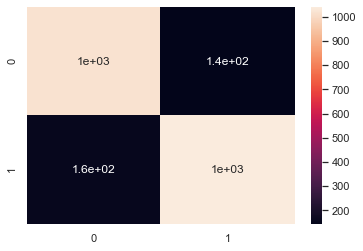

In [117]:
mostra_metricas(y2_test, y_pred)

In [120]:
def nova_predicao(texto):
    texto = clean_text(texto)
    texto_vetorizado = tfidf_vect.transform([texto])
    pred = clf.predict(texto_vetorizado)

    if pred == 0:
        print("Negativa")
    elif pred == 1:
        print("Positiva")
    else:
        print("nem sei")    


In [121]:
nova_predicao('the best app in the world, i like more than other one')

Positiva
